<a href="https://colab.research.google.com/github/Nachi2006/MLREPO/blob/main/finalchildattention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
from google.colab import files

# 1. Upload the kaggle.json file you just downloaded
print("Please upload your kaggle.json file:")
files.upload()

# 2. Move it to the correct folder
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

print("Kaggle API configured successfully!")

Please upload your kaggle.json file:


Saving kaggle.json to kaggle.json
Kaggle API configured successfully!


In [3]:
# Install Kaggle API if not already installed
!pip install kaggle

# Download the datasets
!kaggle datasets download -d programmer3/multimodal-child-emotion-for-learning
!kaggle datasets download -d jangedoo/utkface-new
!kaggle datasets download -d mulukentesfaye/fgnet  # If this link is broken, use aiolapo/fgnet-dataset

# Unzip them
!unzip -q multimodal-child-emotion-for-learning.zip -d multimodal_dataset
!unzip -q utkface-new.zip -d utkface_dataset
!unzip -q fgnet.zip -d fgnet_dataset

Dataset URL: https://www.kaggle.com/datasets/programmer3/multimodal-child-emotion-for-learning
License(s): CC0-1.0
 98% 677M/689M [00:11<00:00, 64.8MB/s]
100% 689M/689M [00:11<00:00, 61.2MB/s]
Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
 92% 304M/331M [00:00<00:00, 569MB/s] 
100% 331M/331M [00:00<00:00, 581MB/s]
Dataset URL: https://www.kaggle.com/datasets/mulukentesfaye/fgnet
License(s): unknown
  0% 0.00/44.1M [00:00<?, ?B/s]
100% 44.1M/44.1M [00:00<00:00, 1.79GB/s]


In [4]:
import os
import shutil
import pandas as pd

# Define paths (adjust these to match your unzipped folder structure)
utk_path = './utkface_dataset/UTKFace'  # Check if it's 'UTKFace' or 'crop_part1'
fgnet_path = './fgnet_dataset/FGNET/images' # Adjust based on actual unzip path
multimodal_path = './multimodal_dataset'

# Output directory
output_dir = './Final_Children_Dataset_2_5'
os.makedirs(output_dir, exist_ok=True)

# --- 1. Filter UTKFace ---
print("Filtering UTKFace...")
for filename in os.listdir(utk_path):
    if not filename.endswith('.jpg'): continue

    # Parse filename: 2_0_0_20170110225557604.jpg.chip.jpg
    parts = filename.split('_')
    try:
        age = int(parts[0])
        if 2 <= age <= 5:
            # We don't have attentive labels, so we save them to a generic folder or 'Unlabeled'
            # You will need to manually sort these later!
            shutil.copy(os.path.join(utk_path, filename), os.path.join(output_dir, f"UTK_{filename}"))
    except ValueError:
        continue

# --- 2. Filter FG-NET ---
print("Filtering FG-NET...")
for filename in os.listdir(fgnet_path):
    # Format example: 001A02.JPG (Subject 1, Age 2)
    # We look for 'A' followed by digits
    upper_name = filename.upper()
    if 'A' in upper_name and (upper_name.endswith('.JPG') or upper_name.endswith('.PNG')):
        try:
            # Extract part after 'A' and before '.'
            age_part = upper_name.split('A')[-1].split('.')[0]
            # Sometimes there are extra suffixes, take first 2 chars just in case
            age = int(''.join(filter(str.isdigit, age_part)))

            if 2 <= age <= 5:
                shutil.copy(os.path.join(fgnet_path, filename), os.path.join(output_dir, f"FGNET_{filename}"))
        except ValueError:
            continue



Filtering UTKFace...
Filtering FG-NET...


In [ ]:
import os

# Path to your final dataset
dataset_path = './Final_Children_Dataset_2_5'

total_count = 0
utk_count = 0
fgnet_count = 0
multimodal_count = 0

print(f"Scanning {dataset_path}...\n")

for root, dirs, files in os.walk(dataset_path):
    for file in files:
        # Check for image extensions
        if file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
            total_count += 1

            # Check prefix to see source (based on previous script)
            if file.startswith("UTK_"):
                utk_count += 1
            elif file.startswith("FGNET_"):
                fgnet_count += 1
            else:
                # Assume anything else is from the Multimodal dataset
                multimodal_count += 1

print("--- Dataset Statistics ---")
print(f"UTKFace images (2-5 yrs):   {utk_count}")
print(f"FG-NET images (2-5 yrs):    {fgnet_count}")
print("-" * 30)
print(f"TOTAL DATASET SIZE:         {total_count} images")

Scanning ./Final_Children_Dataset_2_5...

--- Dataset Statistics ---
UTKFace images (2-5 yrs):   1240
FG-NET images (2-5 yrs):    158
------------------------------
TOTAL DATASET SIZE:         1398 images


In [ ]:
!pip install pigeon-jupyter

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 33.4 MB/s eta 0:00:00
  Created wheel for pigeon-jupyter: filename=pigeon_jupyter-0.1.0-py3-none-any.whl size=3865 sha256=2b02b1f7e45227c0679d978f9b70070012e24e6fca8a4fad2c857d41443d9940
  Stored in directory: /root/.cache/pip/wheels/2c/55/ef/43a86d66313cb16ff952e509365baf5ac3e60516ee4c4405b0
Successfully built pigeon-jupyter


In [ ]:
from pigeon import annotate
import os
from IPython.display import display, Image

# 1. Get list of all image paths
dataset_path = './Final_Children_Dataset_2_5'
all_images = []
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.lower().endswith(('.jpg', '.png', '.jpeg')):
            all_images.append(os.path.join(root, file))

# 2. Start Annotating
# Click 'Attentive' or 'Not_Attentive'.
# Results are saved in 'annotations' list as tuples: (filepath, label)
annotations = annotate(
    all_images,
    options=['Attentive', 'Not_Attentive'],
    display_fn=lambda filename: display(Image(filename, width=300))
)

HTML(value='0 examples annotated, 1399 examples left')

Output()

Annotation done.


In [ ]:
import pandas as pd
df = pd.DataFrame(annotations, columns=['file_path', 'label'])
df.to_csv('attentiveness_labels.csv', index=False)
print("Saved annotations to csv!")

Saved annotations to csv!


In [ ]:
import pandas as pd
import numpy as np
import os
import tensorflow as tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# 1. Load the labels
df = pd.read_csv('attentiveness_labels.csv')

# Check distribution (It's good to have roughly equal numbers)
print("Label Distribution:")
print(df['label'].value_counts())

# 2. Split into Train and Validation sets
# We use stratify to ensure both train and val have a mix of Attentive/Not_Attentive
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

print(f"Training images: {len(train_df)}")
print(f"Validation images: {len(val_df)}")

Label Distribution:
label
Attentive        986
Not_Attentive    412
Name: count, dtype: int64
Training images: 1118
Validation images: 280


Total samples: 1398
label
Attentive        986
Not_Attentive    412
Name: count, dtype: int64
Training samples: 1118
Validation samples: 280


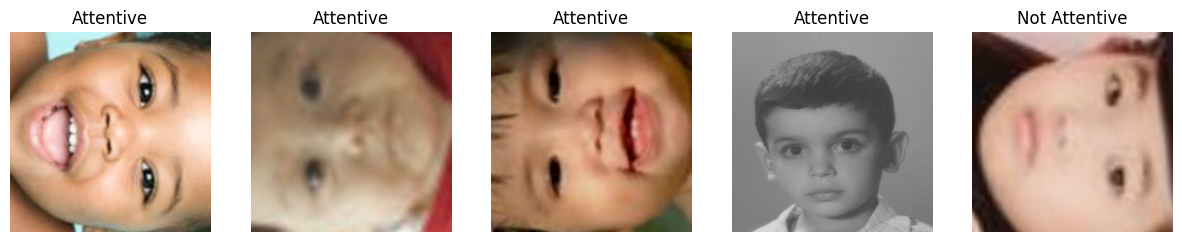

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2
import os

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Load your annotations
df = pd.read_csv('attentiveness_labels.csv')
print(f"Total samples: {len(df)}")
print(df['label'].value_counts())

# Create a dictionary for label encoding
label_dict = {'Attentive': 1, 'Not_Attentive': 0}

# Split data
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df['label'],
    random_state=42
)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")

# Save splits for reference
train_df.to_csv('train_split.csv', index=False)
val_df.to_csv('val_split.csv', index=False)

# Create TensorFlow data pipeline
IMG_SIZE = (224, 224)  # Standard size for most pretrained models
BATCH_SIZE = 32

def load_and_preprocess_image(path, label):
    """Load and preprocess a single image"""
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0,1]
    return image, label

def create_dataset(df, training=False):
    """Create TensorFlow dataset from DataFrame"""
    # Convert labels to integers
    labels = df['label'].map(label_dict).values
    paths = df['file_path'].values

    # Create dataset
    dataset = tf.data.Dataset.from_tensor_slices((paths, labels))

    # Load and preprocess images
    dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

    if training:
        # Apply data augmentation only during training
        dataset = dataset.map(
            lambda x, y: (augment_image(x), y),
            num_parallel_calls=tf.data.AUTOTUNE
        )
        dataset = dataset.shuffle(buffer_size=1000)

    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset

# Define data augmentation
def augment_image(image):
    """Apply augmentations to training images"""
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    # Add slight rotation
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    return image

# Create datasets
train_dataset = create_dataset(train_df, training=True)
val_dataset = create_dataset(val_df, training=False)

# Visualize some samples
def visualize_samples(dataset, num_samples=5):
    plt.figure(figsize=(15, 5))
    for images, labels in dataset.take(1):
        for i in range(min(num_samples, BATCH_SIZE)):
            plt.subplot(1, num_samples, i+1)
            plt.imshow(images[i].numpy())
            plt.title("Attentive" if labels[i].numpy() == 1 else "Not Attentive")
            plt.axis('off')
    plt.show()

visualize_samples(train_dataset)

In [ ]:
def create_transfer_model(model_name='EfficientNetB0'):
    """Create model using transfer learning"""
    # Base model (pretrained on ImageNet, without top layers)
    if model_name == 'EfficientNetB0':
        base_model = keras.applications.EfficientNetB0(
            include_top=False,
            weights='imagenet',
            input_shape=(224, 224, 3)
        )
    elif model_name == 'ResNet50':
        base_model = keras.applications.ResNet50(
            include_top=False,
            weights='imagenet',
            input_shape=(224, 224, 3)
        )
    elif model_name == 'MobileNetV2':
        base_model = keras.applications.MobileNetV2(
            include_top=False,
            weights='imagenet',
            input_shape=(224, 224, 3)
        )

    # Freeze base model initially
    base_model.trainable = False

    # Add custom layers on top
    inputs = keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = keras.Model(inputs, outputs)

    return model, base_model

# Create transfer learning model
model, base_model = create_transfer_model('EfficientNetB0')
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.Precision(name='precision'),
             keras.metrics.Recall(name='recall')]
)

model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,378,788 (16.70 MB)

 Trainable params: 328,705 (1.25 MB)

 Non-trainable params: 4,050,083 (15.45 MB)

In [ ]:
import datetime

# Create callbacks
checkpoint_path = "best_model.keras"

callbacks = [
    # Early stopping
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),

    # Model checkpoint
    keras.callbacks.ModelCheckpoint(
        checkpoint_path,
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),

    # Reduce learning rate on plateau
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),

    # TensorBoard logging
    keras.callbacks.TensorBoard(
        log_dir=f"logs/fit/{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}",
        histogram_freq=1
    )
]

# Train the model
EPOCHS = 50

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

# Plot training history
def plot_training_history(history):
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    # Accuracy
    axes[0, 0].plot(history.history['accuracy'], label='Train')
    axes[0, 0].plot(history.history['val_accuracy'], label='Validation')
    axes[0, 0].set_title('Model Accuracy')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # Loss
    axes[0, 1].plot(history.history['loss'], label='Train')
    axes[0, 1].plot(history.history['val_loss'], label='Validation')
    axes[0, 1].set_title('Model Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # Precision
    axes[1, 0].plot(history.history['precision'], label='Train')
    axes[1, 0].plot(history.history['val_precision'], label='Validation')
    axes[1, 0].set_title('Model Precision')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].legend()
    axes[1, 0].grid(True)

    # Recall
    axes[1, 1].plot(history.history['recall'], label='Train')
    axes[1, 1].plot(history.history['val_recall'], label='Validation')
    axes[1, 1].set_title('Model Recall')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].legend()
    axes[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history)

Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5546 - loss: 0.8311 - precision: 0.7172 - recall: 0.5966
Epoch 1: val_accuracy improved from -inf to 0.70357, saving model to best_model.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 146s 3s/step - accuracy: 0.5551 - loss: 0.8299 - precision: 0.7170 - recall: 0.5984 - val_accuracy: 0.7036 - val_loss: 0.6461 - val_precision: 0.7036 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6802 - loss: 0.6697 - precision: 0.7217 - recall: 0.8946
Epoch 2: val_accuracy did not improve from 0.70357
35/35 ━━━━━━━━━━━━━━━━━━━━ 133s 4s/step - accuracy: 0.6799 - loss: 0.6701 - precision: 0.7215 - recall: 0.8945 - val_accuracy: 0.7036 - val_loss: 0.6125 - val_precision: 0.7036 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6480 - loss: 0.6827 - precision: 0.6973 - recall: 0.8801
Epoch 3: val_accuracy did not improve from 0.70357
35/35 ━━

KeyboardInterrupt: 

=== OVERALL DISTRIBUTION ===
label
Attentive        986
Not_Attentive    412
Name: count, dtype: int64
Attentive: 70.5%

=== TRAINING SET ===
label
Attentive        789
Not_Attentive    329
Name: count, dtype: int64
Attentive: 70.6%

=== VALIDATION SET ===
label
Attentive        197
Not_Attentive     83
Name: count, dtype: int64
Attentive: 70.4%

=== MODEL DIAGNOSTIC ===
⚠️  WARNING: High class imbalance (>65% Attentive)
   Model may be learning to always predict 'Attentive'

=== SAMPLE IMAGES ===


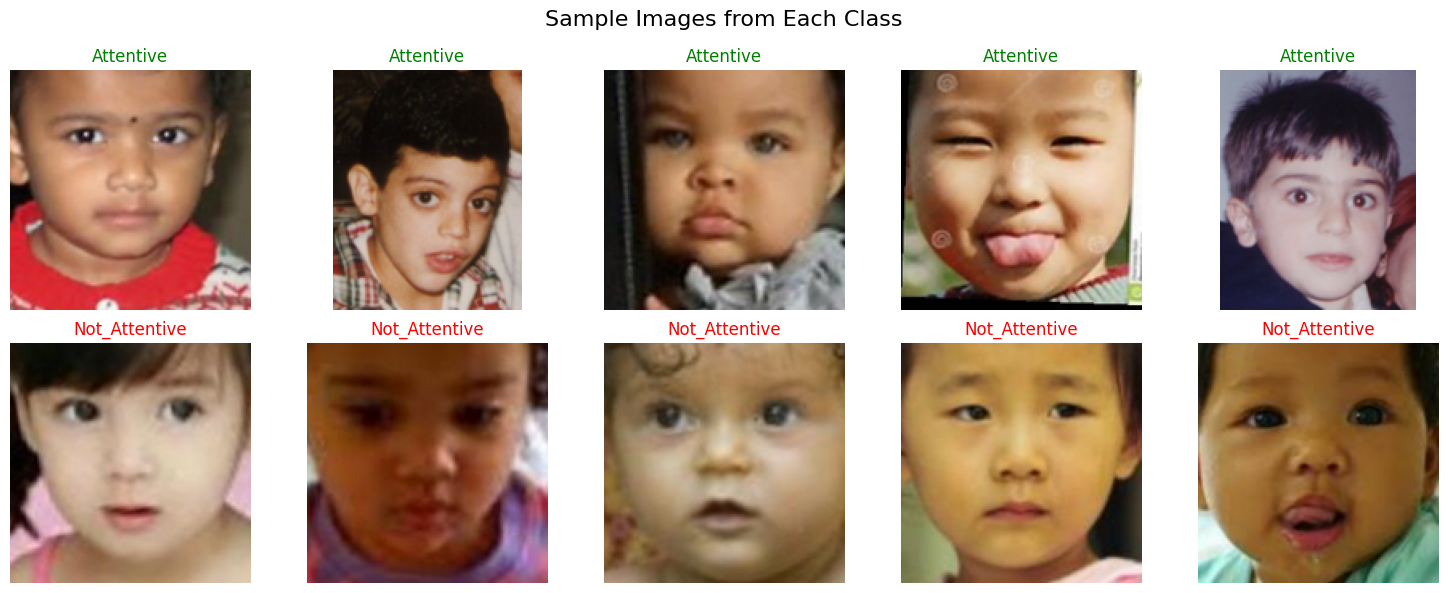

In [ ]:
import pandas as pd
import numpy as np

# Load your data
df = pd.read_csv('attentiveness_labels.csv')

# 1. Check overall distribution
print("=== OVERALL DISTRIBUTION ===")
print(df['label'].value_counts())
print(f"Attentive: {len(df[df['label']=='Attentive'])/len(df):.1%}")

# 2. Check if stratified split worked
train_df = pd.read_csv('train_split.csv')
val_df = pd.read_csv('val_split.csv')

print("\n=== TRAINING SET ===")
print(train_df['label'].value_counts())
print(f"Attentive: {len(train_df[train_df['label']=='Attentive'])/len(train_df):.1%}")

print("\n=== VALIDATION SET ===")
print(val_df['label'].value_counts())
print(f"Attentive: {len(val_df[val_df['label']=='Attentive'])/len(val_df):.1%}")

# 3. Quick model diagnostic
print("\n=== MODEL DIAGNOSTIC ===")
if len(val_df[val_df['label']=='Attentive'])/len(val_df) > 0.65:
    print("⚠️  WARNING: High class imbalance (>65% Attentive)")
    print("   Model may be learning to always predict 'Attentive'")

# 4. Sample check
print("\n=== SAMPLE IMAGES ===")
import matplotlib.pyplot as plt
from PIL import Image

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for idx, (label, group) in enumerate(df.groupby('label')):
    samples = group.sample(5, random_state=42)
    for i, (_, row) in enumerate(samples.iterrows()):
        ax = axes[idx, i]
        img = Image.open(row['file_path'])
        img.thumbnail((150, 150))
        ax.imshow(img)
        ax.set_title(f"{label}", color='green' if label=='Attentive' else 'red')
        ax.axis('off')
plt.suptitle('Sample Images from Each Class', fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

# --- 1. Configuration ---
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
SEED = 42

tf.random.set_seed(SEED)
np.random.seed(SEED)

# --- 2. Load Data ---
if not os.path.exists('attentiveness_labels.csv'):
    raise FileNotFoundError("attentiveness_labels.csv not found.")

df = pd.read_csv('attentiveness_labels.csv')
label_map = {'Attentive': 1, 'Not_Attentive': 0}
df['target'] = df['label'].map(label_map)

# Stratified Split
train_df, val_df = train_test_split(
    df, test_size=0.2, stratify=df['target'], random_state=SEED
)

print(f"Training: {len(train_df)}")
print(f"Validation: {len(val_df)}")

# --- 3. Robust Data Pipeline (MobileNetV2 Style) ---

def load_and_preprocess(path, label):
    """
    Loads image and applies MobileNetV2 specific preprocessing.
    MobileNetV2 expects values between -1 and 1.
    """
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)

    # Cast to float, but DO NOT divide by 255 manually.
    # Let the keras utility handle the specific scaling [-1, 1]
    image = tf.cast(image, tf.float32)
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)

    return image, label

def augment(image, label):
    """
    Applies random transformations to increase data variety.
    """
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    # Random Zoom (Resize + Crop)
    image = tf.image.resize(image, [240, 240])
    image = tf.image.random_crop(image, size=[IMG_SIZE[0], IMG_SIZE[1], 3])
    return image, label

# Train Dataset
train_ds = tf.data.Dataset.from_tensor_slices((train_df['file_path'].values, train_df['target'].values))
train_ds = train_ds.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Validation Dataset
val_ds = tf.data.Dataset.from_tensor_slices((val_df['file_path'].values, val_df['target'].values))
val_ds = val_ds.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# --- 4. Build Model (MobileNetV2) ---

def build_mobilenet_model():
    # MobileNetV2 is lighter and often converges faster on small data
    base_model = keras.applications.MobileNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
    )

    base_model.trainable = False # Start frozen

    inputs = layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    x = base_model(inputs, training=False)

    x = layers.GlobalAveragePooling2D()(x)

    # Simple, robust head
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.2)(x)

    outputs = layers.Dense(1, activation='sigmoid')(x)

    return keras.Model(inputs, outputs)

model = build_mobilenet_model()

# Compile
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.Precision(name='precision'), keras.metrics.Recall(name='recall')]
)

model.summary()

# --- 5. Training ---

# Callbacks
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "best_mobilenet.keras", save_best_only=True, monitor='val_loss', mode='min'
)
early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=8, restore_best_weights=True, monitor='val_loss'
)
reduce_lr_cb = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6
)

print("\nStarting Training (MobileNetV2)...")

# We REMOVE class_weight for now to let the model stabilize naturally.
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[checkpoint_cb, early_stopping_cb, reduce_lr_cb]
)

# --- 6. Plotting ---
def plot_results(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Train Acc')
    plt.plot(epochs, val_acc, label='Val Acc')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Val Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()

plot_results(history)

Training: 1118
Validation: 280


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        81,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,345,153 (8.95 MB)

 Trainable params: 84,609 (330.50 KB)

 Non-trainable params: 2,260,544 (8.62 MB)


Starting Training (MobileNetV2)...
Epoch 1/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.5292 - loss: 0.9479 - precision: 0.7451 - recall: 0.5178 - val_accuracy: 0.6679 - val_loss: 0.6461 - val_precision: 0.7131 - val_recall: 0.8832 - learning_rate: 0.0010
Epoch 2/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.7044 - loss: 0.6544 - precision: 0.7611 - recall: 0.8389 - val_accuracy: 0.7071 - val_loss: 0.6355 - val_precision: 0.7186 - val_recall: 0.9594 - learning_rate: 0.0010
Epoch 3/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.7715 - loss: 0.4785 - precision: 0.8094 - recall: 0.8927 - val_accuracy: 0.7107 - val_loss: 0.6060 - val_precision: 0.7231 - val_recall: 0.9543 - learning_rate: 0.0010
Epoch 4/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.7805 - loss: 0.4626 - precision: 0.8159 - recall: 0.8889 - val_accuracy: 0.6964 - val_loss: 0.6233 - val_precision: 0.7276 - val_recall: 0.9086 - learning_rate: 0.0010
Epoch 5/30
35/35 ━━━━━━━━━━━━━━━━━━━

KeyboardInterrupt: 

In [ ]:
import json

# 1. Define your notebook filename
notebook_filename = 'Untitled0.ipynb'

# 2. Open the file
with open(notebook_filename, 'r', encoding='utf-8') as f:
    data = json.load(f)

# 3. Remove the broken 'widgets' metadata
if 'widgets' in data['metadata']:
    print("Found broken widget metadata. Removing...")
    del data['metadata']['widgets']

    # 4. Save the fixed file
    with open(notebook_filename, 'w', encoding='utf-8') as f:
        json.dump(data, f, indent=1)
    print("Fixed! You can now render/download the notebook.")
else:
    print("No widget metadata found. The file might already be clean.")

FileNotFoundError: [Errno 2] No such file or directory: 'Untitled0.ipynb'

In [1]:
!pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 38.3/112.6 GB disk)


In [5]:
import os
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

# --- Configuration ---
# Your existing CSV and Source Folder
CSV_FILE = '/content/attentiveness_labels.csv'
SOURCE_IMG_DIR = '/content/Final_Children_Dataset_2_5' # Or wherever your current images are. If they are inside Final_Children_Dataset_2_5, put that here.

# Where we will create the YOLO dataset
YOLO_DIR = 'content/yolo_dataset'

# --- 1. Load and Split Data ---
df = pd.read_csv(CSV_FILE)

# Split into Train (80%) and Val (20%)
train_df, val_df = train_test_split(
    df, test_size=0.2, stratify=df['label'], random_state=42
)

print(f"Training Samples: {len(train_df)}")
print(f"Validation Samples: {len(val_df)}")

# --- 2. Move Files ---
def setup_yolo_dir(df, split_name):
    for _, row in tqdm(df.iterrows(), total=len(df), desc=f"Processing {split_name}"):
        label = row['label']
        src_path = row['file_path']

        # Define destination: yolo_dataset/train/Attentive/image.jpg
        dest_folder = os.path.join(YOLO_DIR, split_name, label)
        os.makedirs(dest_folder, exist_ok=True)

        # Get filename and copy
        filename = os.path.basename(src_path)
        dest_path = os.path.join(dest_folder, filename)

        try:
            shutil.copy(src_path, dest_path)
        except FileNotFoundError:
            print(f"Warning: Could not find {src_path}")

# Clear previous runs if any
if os.path.exists(YOLO_DIR):
    shutil.rmtree(YOLO_DIR)

setup_yolo_dir(train_df, 'train')
setup_yolo_dir(val_df, 'val')

print("\nData restructuring complete!")
print(f"Dataset ready at: {YOLO_DIR}")

Training Samples: 1118
Validation Samples: 280


Processing train:   0%|          | 0/1118 [00:00<?, ?it/s]

Processing val:   0%|          | 0/280 [00:00<?, ?it/s]


Data restructuring complete!
Dataset ready at: content/yolo_dataset


In [7]:
from ultralytics import YOLO

# 1. Load the Nano Classification model (pretrained on ImageNet)
model = YOLO('yolov8n-cls.pt')

# 2. Train the model
results = model.train(
    data='content/yolo_dataset',  # Path to the folder we created above
    epochs=30,              # YOLO usually converges fast
    imgsz=224,              # Standard size
    batch=32,
    dropout=0.3,            # Add dropout to fight overfitting
    patience=5,             # Early stopping
    project='child_attention_project',
    name='yolo_nano_run'
)

Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=content/yolo_dataset, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.3, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo_nano_run2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=5, perspective=0.0, plots=True, pos

Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
train: /content/content/yolo_dataset/train... found 1118 images in 2 classes ✅ 
val: /content/content/yolo_dataset/val... found 280 images in 2 classes ✅ 
test: None...
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1109.1±511.7 MB/s, size: 34.8 KB)
val: Scanning /content/content/yolo_dataset/val... 280 images, 0 corrupt: 100% ━━━━━━━━━━━━ 280/280 358.5Kit/s 0.0s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 18/18 19.0it/s 0.9s
                   all      0.754          1
Speed: 0.3ms preprocess, 1.4ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /content/runs/classify/val18
Top-1 Accuracy: 0.7536

image 1/1 /content/content/yolo_dataset/val/Not_Attentive/UTK_3_1_3_20161220220451762.jpg.chip.jpg: 224x224 Attentive 0.83, Not_Attentive 0.17, 2.8ms
Speed: 3.0ms preprocess, 2.8ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)


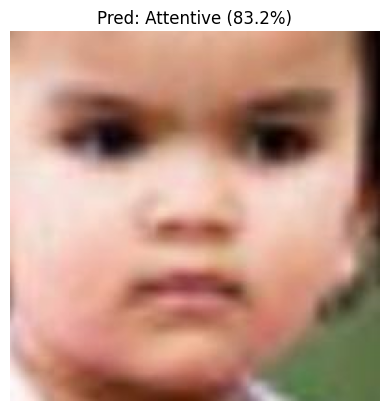

In [25]:
import matplotlib.pyplot as plt
import cv2
import glob
import random

# 1. Validate on the held-out validation set
metrics = model.val()
print(f"Top-1 Accuracy: {metrics.top1:.4f}")

# 2. Run Inference on a random validation image
val_images = glob.glob('content/yolo_dataset/val/*/*.jpg')
test_image_path = random.choice(val_images)

# Predict
results = model(test_image_path)

# Visualize
img = cv2.imread(test_image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

# Results object contains the probabilities
probs = results[0].probs
class_index = probs.top1
class_name = results[0].names[class_index]
confidence = probs.top1conf.item()

plt.title(f"Pred: {class_name} ({confidence:.1%})")
plt.axis('off')
plt.show()

IndexError: Cannot choose from an empty sequence

In [33]:
!pip install grad-cam


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 63.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=60cce8969dbe6bf4e7e3382abfe9681226336c29b1cfeea70dc5bdf900e21068
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam


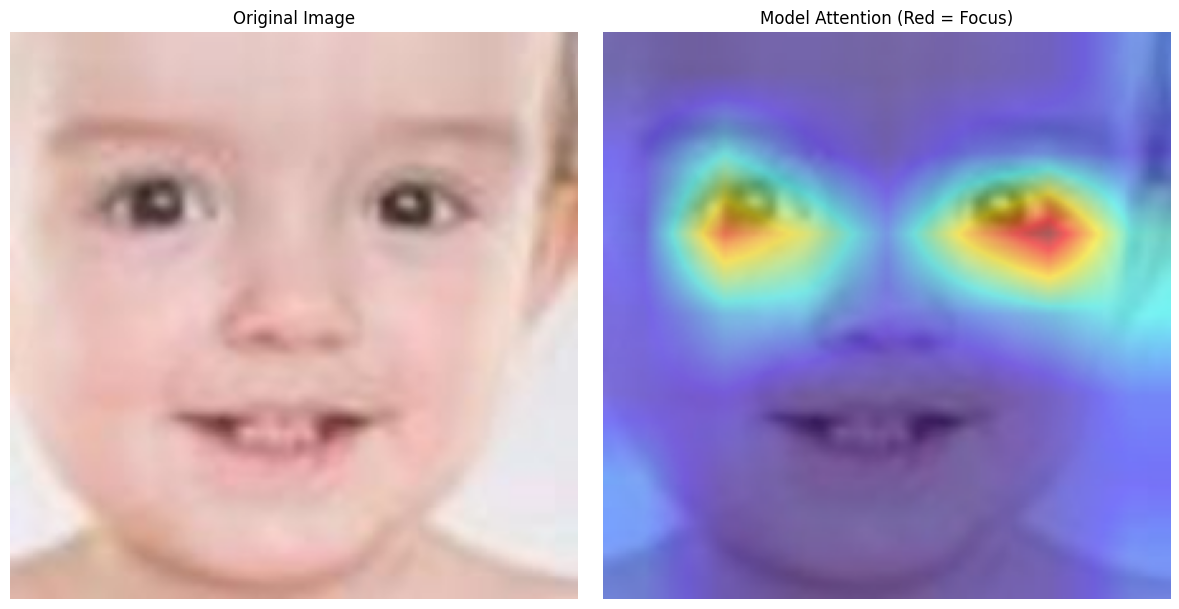

Explained image: /content/content/yolo_dataset/val/Attentive/UTK_2_0_0_20161219204329404.jpg.chip.jpg


In [49]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from ultralytics import YOLO
import glob
import random

# --- 1. Define the Wrapper ---
class YOLOv8Wrapper(torch.nn.Module):
    def __init__(self, model):
        super(YOLOv8Wrapper, self).__init__()
        self.model = model

    def forward(self, x):
        result = self.model(x)
        if isinstance(result, tuple):
            return result[0]
        return result

# --- 2. Configuration ---
model_path = "/content/child_attention_project/yolo_nano_run2/weights/best.pt"

# FIX: Check if path has double '/content'. I used a safer glob pattern here.
# Try to find images in the standard path first
search_path = "/content/yolo_dataset/val/Attentive/*.jpg"
files = glob.glob(search_path)

# If not found, try the path you had in your snippet
if not files:
    search_path = "/content/content/yolo_dataset/val/Attentive/*.jpg"
    files = glob.glob(search_path)

if not files:
    raise FileNotFoundError(f"Could not find any images! Check your path: {search_path}")

image_path = random.choice(files)

# --- 3. Load and Wrap the Model ---
yolo_model = YOLO(model_path)
model = YOLOv8Wrapper(yolo_model.model)
model.eval() # Ensure model is in evaluation mode

# --- 4. Identify Target Layer ---
target_layers = [model.model.model[-2]]

# --- 5. Prepare Image ---
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (224, 224))
rgb_img = np.float32(img) / 255
input_tensor = preprocess_image(rgb_img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# !!! THIS IS THE MISSING LINE THAT FIXES YOUR ERROR !!!
input_tensor.requires_grad = True

# --- 6. Generate Heatmap ---
cam = GradCAM(model=model, target_layers=target_layers)
grayscale_cam = cam(input_tensor=input_tensor, targets=None)
grayscale_cam = grayscale_cam[0, :]

# --- 7. Visualize ---
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].imshow(img)
axs[0].set_title("Original Image")
axs[0].axis('off')

axs[1].imshow(visualization)
axs[1].set_title("Model Attention (Red = Focus)")
axs[1].axis('off')

plt.tight_layout()
plt.show()

print(f"Explained image: {image_path}")

=============== 1. TRAINING CURVES ===============


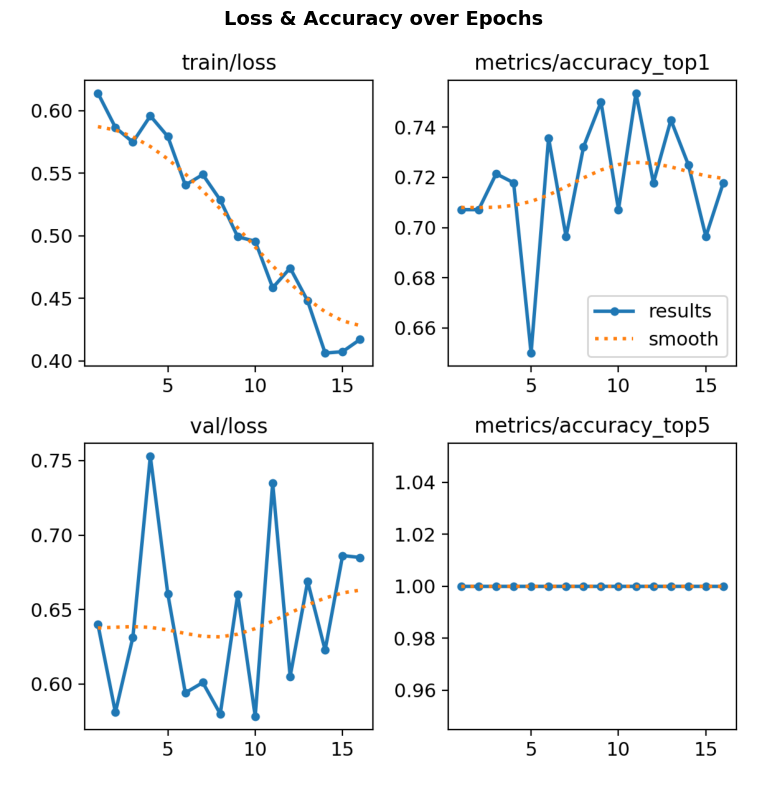


=============== 2. CONFUSION MATRIX ===============


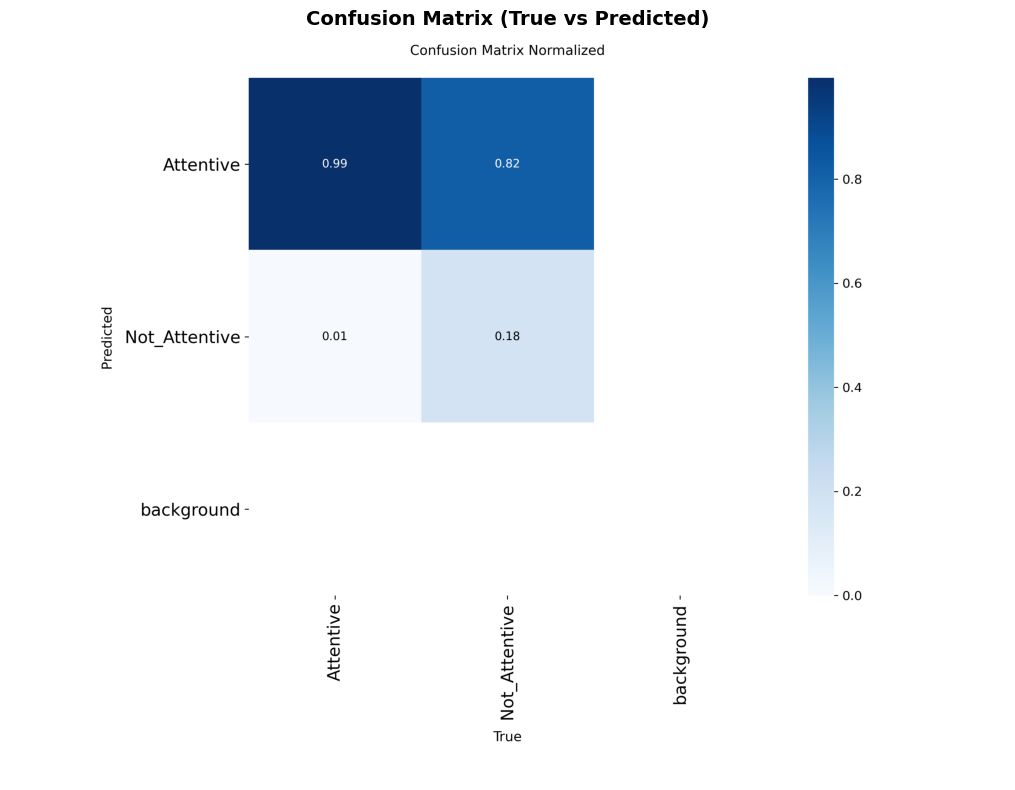


=============== 3. VALIDATION BATCH PREDICTIONS ===============


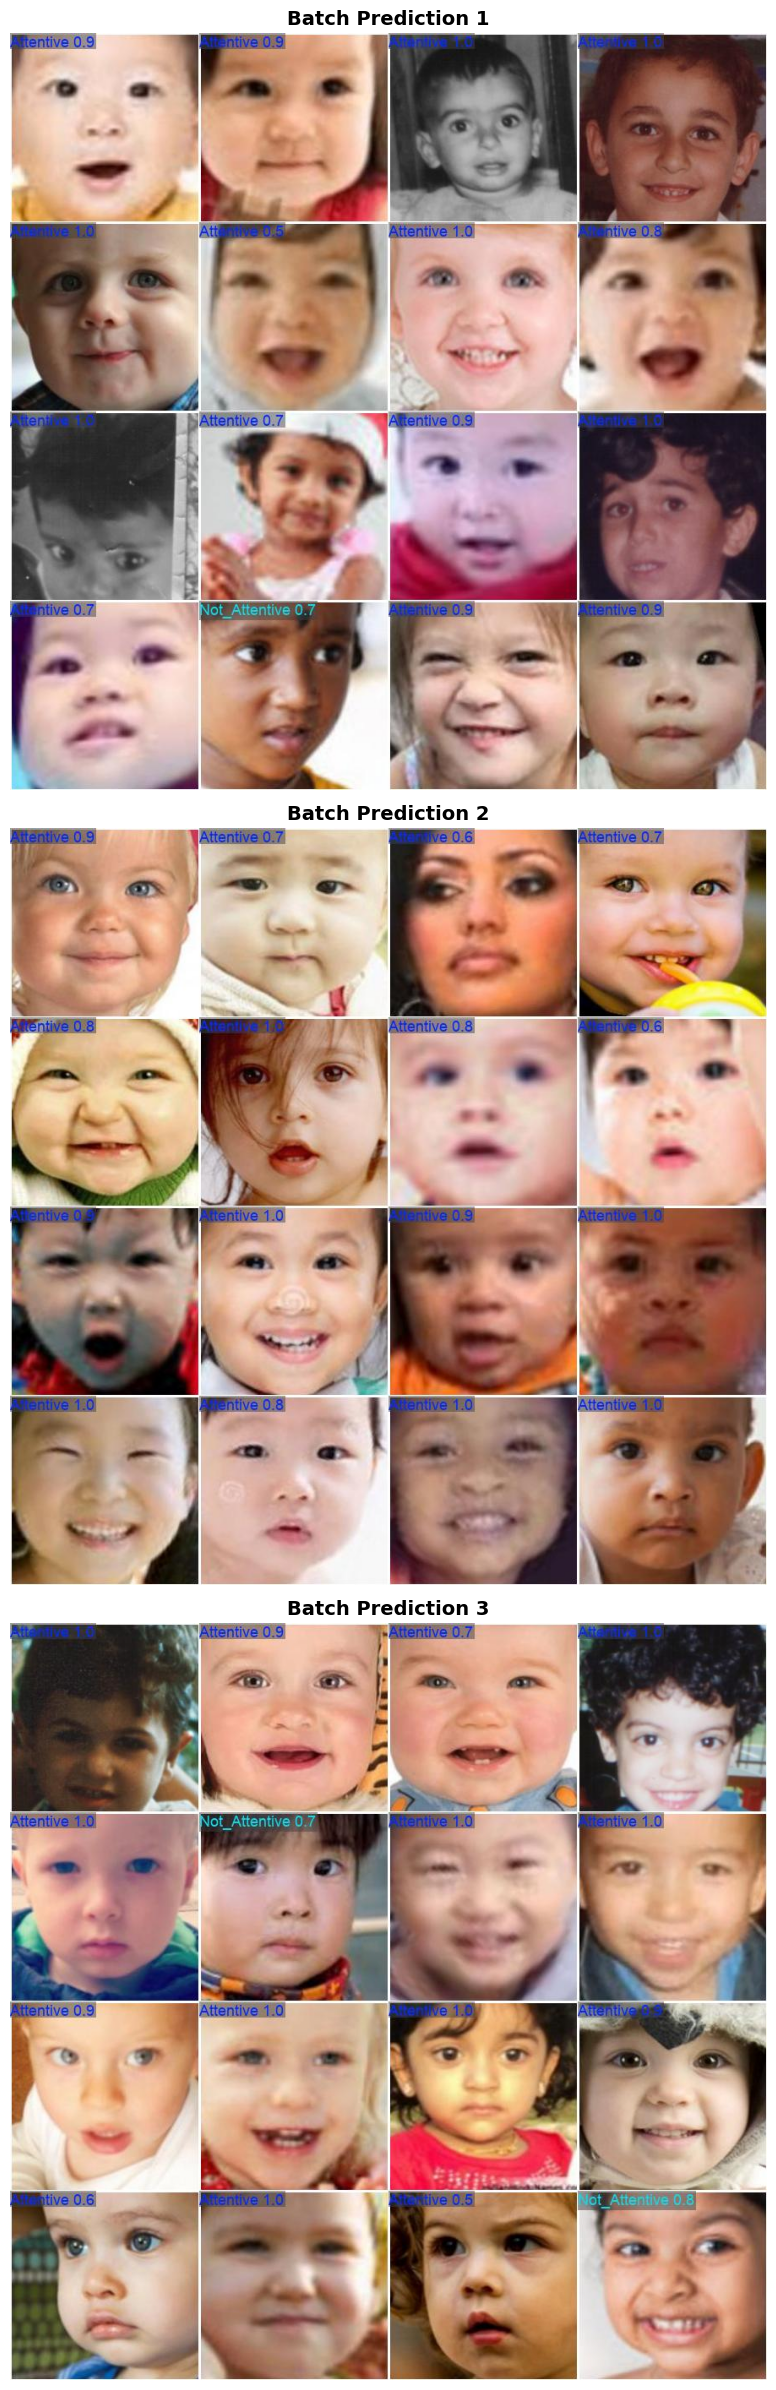


=============== 4. TRAINING DATA SAMPLES (AUGMENTED) ===============


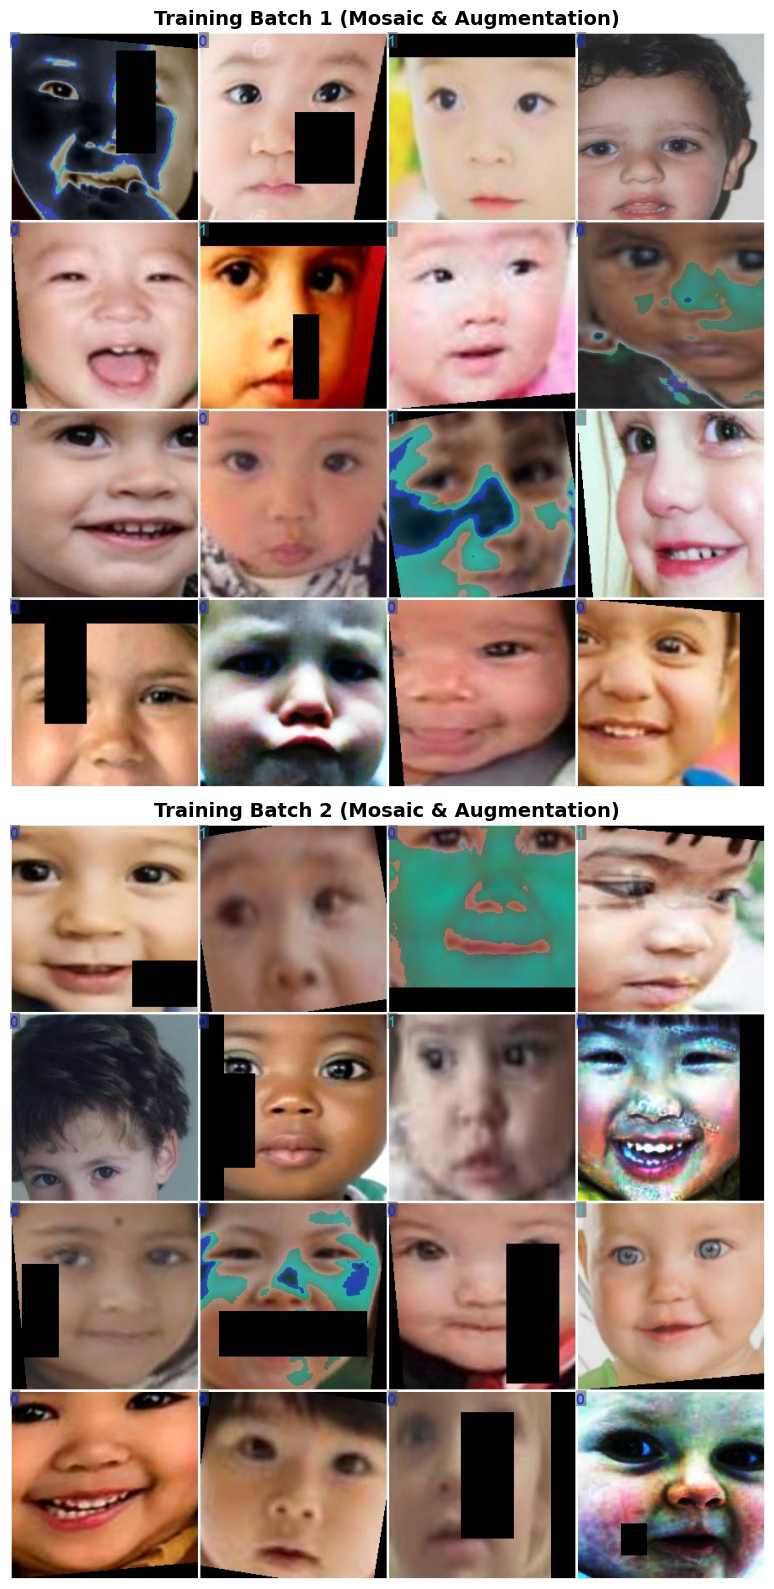

In [50]:
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# --- CONFIGURATION ---
# The folder where your training results are stored
RUN_FOLDER = "/content/child_attention_project/yolo_nano_run2"

def display_images_in_grid(image_paths, titles):
    """Helper to plot images in a nice grid"""
    if not image_paths:
        print("No images found for this section.")
        return

    num_images = len(image_paths)
    fig, axes = plt.subplots(num_images, 1, figsize=(12, 8 * num_images))

    if num_images == 1:
        axes = [axes] # Make iterable if single image

    for ax, img_path, title in zip(axes, image_paths, titles):
        try:
            img = mpimg.imread(img_path)
            ax.imshow(img)
            ax.set_title(title, fontsize=14, fontweight='bold')
            ax.axis('off')
        except Exception as e:
            print(f"Could not read {img_path}: {e}")

    plt.tight_layout()
    plt.show()

# --- 1. PERFORMANCE CURVES (Loss & Accuracy) ---
print("="*15 + " 1. TRAINING CURVES " + "="*15)
results_path = os.path.join(RUN_FOLDER, "results.png")
if os.path.exists(results_path):
    display_images_in_grid([results_path], ["Loss & Accuracy over Epochs"])
else:
    print("❌ 'results.png' not found. Training might not have finished.")

# --- 2. CONFUSION MATRIX ---
print("\n" + "="*15 + " 2. CONFUSION MATRIX " + "="*15)
# Check for normalized first, then standard
cm_paths = [
    os.path.join(RUN_FOLDER, "confusion_matrix_normalized.png"),
    os.path.join(RUN_FOLDER, "confusion_matrix.png")
]
found_cms = [p for p in cm_paths if os.path.exists(p)]

if found_cms:
    # Display the best available one
    display_images_in_grid([found_cms[0]], ["Confusion Matrix (True vs Predicted)"])
else:
    print("❌ Confusion Matrix not found.")

# --- 3. MODEL PREDICTIONS (What the model sees) ---
print("\n" + "="*15 + " 3. VALIDATION BATCH PREDICTIONS " + "="*15)
# YOLO saves images named like 'val_batch0_pred.jpg'
pred_files = glob.glob(os.path.join(RUN_FOLDER, "val_batch*_pred.jpg"))
pred_files.sort() # Show in order

if pred_files:
    titles = [f"Batch Prediction {i+1}" for i in range(len(pred_files))]
    display_images_in_grid(pred_files, titles)
else:
    print("❌ No validation prediction images found.")

# --- 4. TRAINING MOSAICS (Data Augmentation Check) ---
print("\n" + "="*15 + " 4. TRAINING DATA SAMPLES (AUGMENTED) " + "="*15)
# These show how YOLO distorted your images during training
train_batch_files = glob.glob(os.path.join(RUN_FOLDER, "train_batch*.jpg"))
train_batch_files.sort()

# Just show the first 2 batches to save space
if train_batch_files:
    display_files = train_batch_files[:2]
    titles = [f"Training Batch {i+1} (Mosaic & Augmentation)" for i in range(len(display_files))]
    display_images_in_grid(display_files, titles)
else:
    print("❌ No training batch images found.")

🚀 Starting End-to-End Pipeline on content/yolo_dataset...

--- PHASE 1: Checking Class Balance ---
   • Attentive: 789 images
   • Not_Attentive: 329 images

Target count per class: 789
   ✓ 'Attentive' is already the majority class.
   ⟳ Balancing 'Not_Attentive'... Duplicating 460 images.
   ✅ 'Not_Attentive' is now balanced with 789 images.

Dataset is now perfectly balanced.

--- PHASE 2: Starting Training ---
Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=content/yolo_dataset, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.4, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, f

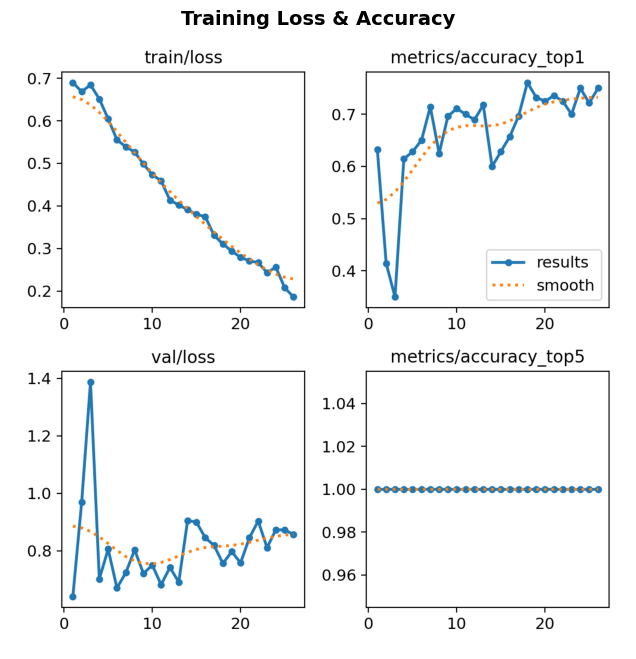

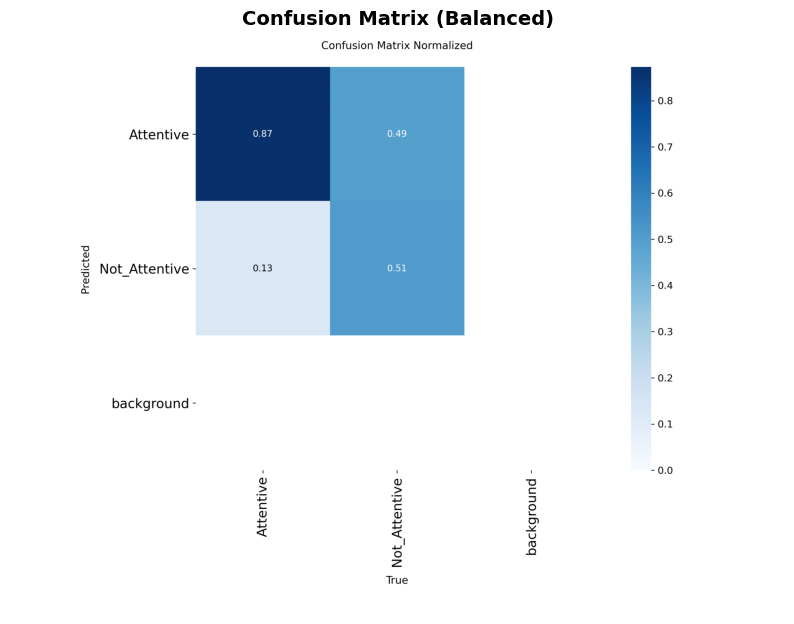


✅ SUCCESS! Best model saved at: child_attention_project/yolo_balanced_run/weights/best.pt


In [51]:
import os
import shutil
import glob
import random
import uuid
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from ultralytics import YOLO
from IPython.display import display, Image

# --- CONFIGURATION ---
DATASET_PATH = 'content/yolo_dataset'
TRAIN_DIR = os.path.join(DATASET_PATH, 'train')
CLASSES = ['Attentive', 'Not_Attentive']
PROJECT_NAME = 'child_attention_project'
RUN_NAME = 'yolo_balanced_run'

print(f"🚀 Starting End-to-End Pipeline on {DATASET_PATH}...\n")

# ==========================================
# PHASE 1: AUTOMATIC REBALANCING
# ==========================================
print("--- PHASE 1: Checking Class Balance ---")

# 1. Get counts
counts = {}
files_map = {}

for cls in CLASSES:
    cls_path = os.path.join(TRAIN_DIR, cls)
    # Get all images
    files = glob.glob(os.path.join(cls_path, "*.*"))
    counts[cls] = len(files)
    files_map[cls] = files
    print(f"   • {cls}: {len(files)} images")

# 2. Determine target count (max of the two)
target_count = max(counts.values())
print(f"\nTarget count per class: {target_count}")

# 3. Oversample minority classes
for cls in CLASSES:
    current = counts[cls]
    needed = target_count - current

    if needed > 0:
        print(f"   ⟳ Balancing '{cls}'... Duplicating {needed} images.")
        cls_path = os.path.join(TRAIN_DIR, cls)

        # Randomly sample existing files to duplicate
        src_files = files_map[cls]

        for _ in range(needed):
            src = random.choice(src_files)
            # Create unique name: original_uuid.jpg
            fname = os.path.basename(src)
            name, ext = os.path.splitext(fname)
            new_name = f"{name}_aug_{uuid.uuid4().hex[:8]}{ext}"
            dst = os.path.join(cls_path, new_name)

            shutil.copy(src, dst)

        print(f"   ✅ '{cls}' is now balanced with {target_count} images.")
    else:
        print(f"   ✓ '{cls}' is already the majority class.")

print("\nDataset is now perfectly balanced.\n")

# ==========================================
# PHASE 2: TRAINING (YOLOv8-Nano)
# ==========================================
print("--- PHASE 2: Starting Training ---")

# Load Nano model (pretrained)
model = YOLO('yolov8n-cls.pt')

# Train
# We increase patience to 8 to give it time to learn the new balanced data
results = model.train(
    data=DATASET_PATH,
    epochs=30,
    imgsz=224,
    batch=32,
    dropout=0.4,          # Increased dropout slightly to prevent overfitting on duplicates
    patience=8,
    project=PROJECT_NAME,
    name=RUN_NAME,
    exist_ok=True,        # Overwrite if exists
    verbose=True
)

print("\nTraining Complete.\n")

# ==========================================
# PHASE 3: VISUALIZATION & VERIFICATION
# ==========================================
print("--- PHASE 3: Verifying Results ---")

# Construct path to results
run_folder = os.path.join(PROJECT_NAME, RUN_NAME)
results_img = os.path.join(run_folder, 'results.png')
cm_img = os.path.join(run_folder, 'confusion_matrix_normalized.png')

def show_img(path, title):
    if os.path.exists(path):
        img = mpimg.imread(path)
        plt.figure(figsize=(10, 8))
        plt.imshow(img)
        plt.title(title, fontsize=14, fontweight='bold')
        plt.axis('off')
        plt.show()
    else:
        print(f"❌ Could not find {title} at {path}")

# Display
show_img(results_img, "Training Loss & Accuracy")
show_img(cm_img, "Confusion Matrix (Balanced)")

# Check the weights file
weights_path = os.path.join(run_folder, 'weights/best.pt')
if os.path.exists(weights_path):
    print(f"\n✅ SUCCESS! Best model saved at: {weights_path}")
else:
    print("\n⚠️ Warning: Weights file not found. Check training logs.")

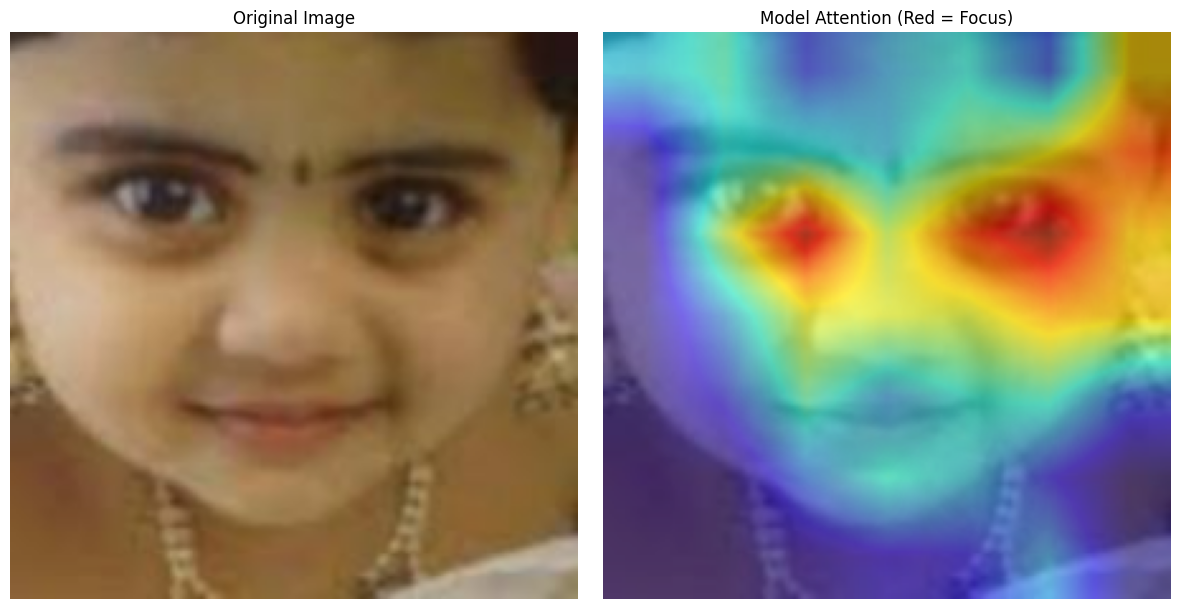

Explained image: /content/content/yolo_dataset/val/Attentive/UTK_4_1_3_20161220222145586.jpg.chip.jpg


In [54]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from ultralytics import YOLO
import glob
import random

# --- 1. Define the Wrapper ---
class YOLOv8Wrapper(torch.nn.Module):
    def __init__(self, model):
        super(YOLOv8Wrapper, self).__init__()
        self.model = model

    def forward(self, x):
        result = self.model(x)
        if isinstance(result, tuple):
            return result[0]
        return result

# --- 2. Configuration ---
model_path = "/content/child_attention_project/yolo_balanced_run/weights/best.pt"

# FIX: Check if path has double '/content'. I used a safer glob pattern here.
# Try to find images in the standard path first
search_path = "/content/yolo_dataset/val/Attentive/*.jpg"
files = glob.glob(search_path)

# If not found, try the path you had in your snippet
if not files:
    search_path = "/content/content/yolo_dataset/val/Attentive/*.jpg"
    files = glob.glob(search_path)

if not files:
    raise FileNotFoundError(f"Could not find any images! Check your path: {search_path}")

image_path = random.choice(files)

# --- 3. Load and Wrap the Model ---
yolo_model = YOLO(model_path)
model = YOLOv8Wrapper(yolo_model.model)
model.eval() # Ensure model is in evaluation mode

# --- 4. Identify Target Layer ---
target_layers = [model.model.model[-2]]

# --- 5. Prepare Image ---
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (224, 224))
rgb_img = np.float32(img) / 255
input_tensor = preprocess_image(rgb_img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# !!! THIS IS THE MISSING LINE THAT FIXES YOUR ERROR !!!
input_tensor.requires_grad = True

# --- 6. Generate Heatmap ---
cam = GradCAM(model=model, target_layers=target_layers)
grayscale_cam = cam(input_tensor=input_tensor, targets=None)
grayscale_cam = grayscale_cam[0, :]

# --- 7. Visualize ---
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].imshow(img)
axs[0].set_title("Original Image")
axs[0].axis('off')

axs[1].imshow(visualization)
axs[1].set_title("Model Attention (Red = Focus)")
axs[1].axis('off')

plt.tight_layout()
plt.show()

print(f"Explained image: {image_path}")